In [ ]:
import nltk
import plotly.express as px
import pandas as pd
from nltk.tokenize import word_tokenize # sirve para separa las oraciones a palabras
from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from collections import defaultdict
from sklearn import model_selection, naive_bayes, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import numpy as np
from wordcloud import WordCloud

**1.	Cargar en Colab, los 3 elementos es decir el código en el notebook, la imagen y la base de datos de tweets etiquetadas**

In [ ]:
nltk.download() #escoger d) y lista wordnet, punkt,averaged_perceptron_tagger y stopwords luego q)

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> wordnet


      Package wordnet is already up-to-date!



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt


      Package punkt is already up-to-date!



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> averaged_perceptron_tagger


        /root/nltk_data...
      Unzipping taggers/averaged_perceptron_tagger.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords


      Unzipping corpora/stopwords.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:
names = ['Id', 'tweet', 'polaridad']
dataset = pd.read_csv('train.txt', sep='\t',names=names)
df=pd.DataFrame(dataset)
df['tweet'] = [entry.lower() for entry in df['tweet']]
trump_mask = np.array(Image.open("heart.jpg"))

In [ ]:
dataset.head(4)

,Id,tweet,polaridad
0,818942405281980417,no mames este pinche dolor que pedo? ya mejor ...,N
1,818963123646373892,"@leomall2018 según yo era como aviso, pero aho...",NEU
2,818998133694697472,@benshorts a juzgar por mis comportamientos au...,N
3,818822556090105857,#buenosdias mundo twittero ya desperté y estoy...,P


**2**.	Ejecutar el notebook compartido analizando previamente lla información de la base de datos

In [ ]:
df['tweet'] = df.apply(lambda row: nltk.word_tokenize(row['tweet']), axis=1)
tag_map = defaultdict(lambda : wordnet.NOUN) #se crea el diccionario
tag_map['J','V','R'] = wordnet.ADJ,wordnet.VERB,wordnet.ADV # Se define los 3 campos en este caso para hacer una comparacion de tipo,y bajarlo a "lenguaje estandar"
for index,entry in enumerate(df['tweet']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('spanish') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    df.loc[index,'Palabras_claves'] = str(Final_words)

In [ ]:
df.head(4)

,Id,tweet,polaridad,Palabras_claves
0,818942405281980417,"[no, mames, este, pinche, dolor, que, pedo, ?,...",N,"['mames', 'pinche', 'dolor', 'pedo', 'mejor', ..."
1,818963123646373892,"[@, leomall2018, según, yo, era, como, aviso, ...",NEU,"['según', 'aviso', 'ahora', 'oficial']"
2,818998133694697472,"[@, benshorts, a, juzgar, por, mis, comportami...",N,"['benshorts', 'juzgar', 'comportamientos', 'au..."
3,818822556090105857,"[#, buenosdias, mundo, twittero, ya, desperté,...",P,"['buenosdias', 'mundo', 'twittero', 'desperté'..."


In [ ]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df.Palabras_claves,df.polaridad,test_size=0.3)
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['Palabras_claves'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

 **3.	Identificar que algoritmo es más preciso**

In [ ]:
# Clasificador - Algoritmo - Naive Bayes
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
predictions_NB = Naive.predict(Test_X_Tfidf)
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  58.58585858585859


In [ ]:
# Clasificador - Algoritmo - SVM
SVM = svm.SVC(C=1.20, kernel='linear', degree=3, gamma='auto',   max_iter=1000,  tol=0.0001)
SVM.fit(Train_X_Tfidf,Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  61.27946127946128


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


 **4**.	Generar la matriz de confusión

[Text(0, 0.5, 'Positivos'), Text(0, 1.5, 'Neutros'), Text(0, 2.5, 'Negativos')]

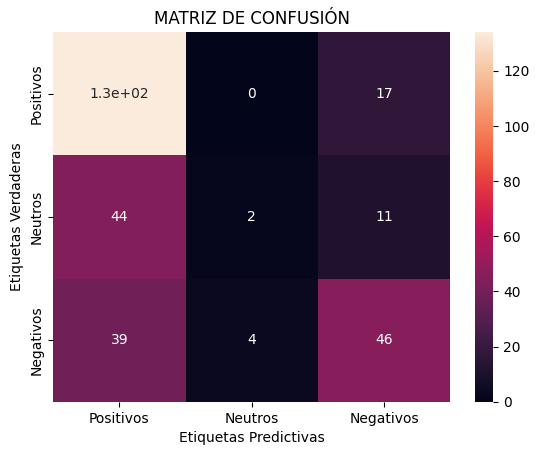

In [ ]:
y_pred = SVM.predict(Test_X_Tfidf)
cm = confusion_matrix(Test_Y, y_pred, labels=[0, 1, 2])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Etiquetas Predictivas');ax.set_ylabel('Etiquetas Verdaderas')
ax.set_title('MATRIZ DE CONFUSIÓN')
ax.xaxis.set_ticklabels(['Positivos', 'Neutros','Negativos']); ax.yaxis.set_ticklabels(['Positivos', 'Neutros','Negativos'])

 **5**.	Revisar el top de las 20 palabras más usadas

In [ ]:
names = ['Id', 'tweet', 'polaridad']
palabras = pd.read_csv('train.txt', sep='\t',names=names)
palabras['tweet2'] = palabras.tweet.str.strip().str.split('[\W_]+')

In [ ]:
rows = list()
for row in palabras[['tweet2']].iterrows():
    r = row[1]
    for word in r.tweet2:
        rows.append((word))

tweet2 = pd.DataFrame(rows, columns=['tweet2'])

In [ ]:
tweet2 = tweet2[tweet2.tweet2.str.len() > 0]
tweet2['tweet2'] = tweet2.tweet2.str.lower()
counts = tweet2\
    .tweet2.value_counts()\
    .to_frame()\
    .rename(columns={'tweet2':'Repetitividad'})

<ipython-input-20-469d8bda736d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet2['tweet2'] = tweet2.tweet2.str.lower()


In [ ]:
stopwords = stopwords.words('spanish')
for a_stopword in stopwords:
    if a_stopword in counts.index:
        counts = counts.drop(a_stopword)

In [ ]:
top_20 = counts.head(20)
top_20

,Repetitividad
si,127
año,63
mejor,50
quiero,50
bien,49
tan,47
días,42
hoy,40
vida,40
así,40


 **6.	Generar la nube de palabra**

In [ ]:
comment_words = ' '
for val in counts.index:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    for words in tokens:
        comment_words = comment_words + words + ' '

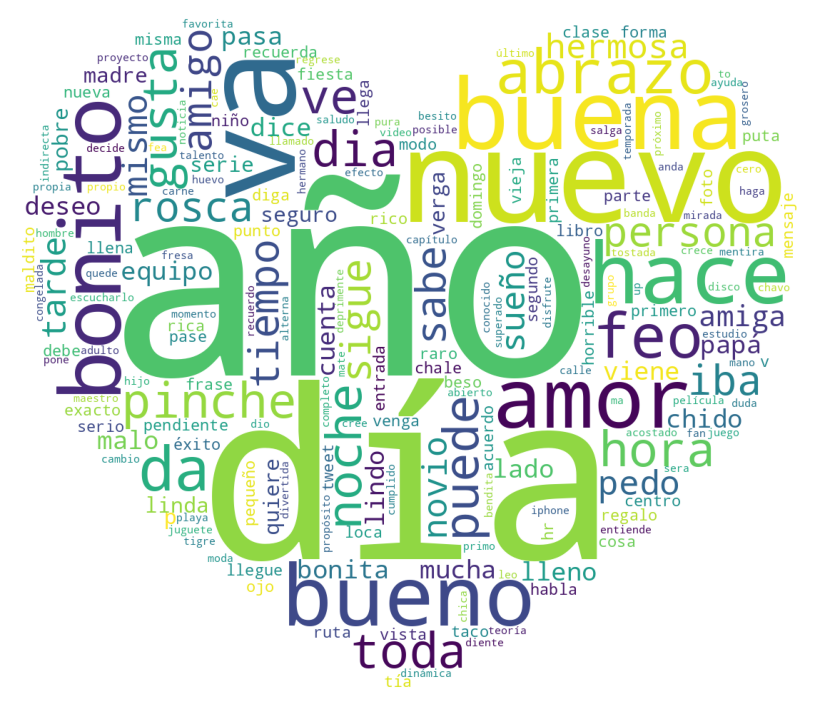

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                mask=trump_mask,
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()